In [ ]:
''' install the desired pytorch version '''
!pip3 install torch==1.2.0+cu92 torchvision==0.4.0+cu92 -f https://download.pytorch.org/whl/torch_stable.html


Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 663.1 MB 1.6 kB/s 
     |████████████████████████████████| 8.8 MB 557 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.2.0+cu92 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.2.0+cu92 which is incompatible.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
''' importing the neccessary libraries '''
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import cv2
import matplotlib.pyplot as plt

from collections import OrderedDict

import pdb
from math import sqrt, ceil

from torch.autograd import Variable

from PIL import Image

from functools import partial
import sys

import cv2




In [ ]:
#check device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device
print(torch.__version__)

1.2.0+cu92


In [ ]:
from torchvision import datasets
''' load dataset in the appropriate manner '''
BATCH_SIZE = 32

## transforms are used to convert the data to tensors for easy use with CNN models
transform = transforms.Compose([transforms.ToTensor()])

# downloading the training data through Pytorch API
train_data = datasets.MNIST( 
    root = './data',
    train = True,
    transform = transform,
    download = True
)
#note num_workers attribute tells the number of workers(threads) that performs the task
#other attributes are pretty self-explanatory
#loading the training data 
train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers = 2)

# downloading the test data through Pytorch API
test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = transform,
    download = True
)
#loading the test data 
test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers = 2
)

9920512it [00:00, 70652472.37it/s]                             

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


32768it [00:00, 1155454.09it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


1654784it [00:00, 22428027.66it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


8192it [00:00, 281614.12it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


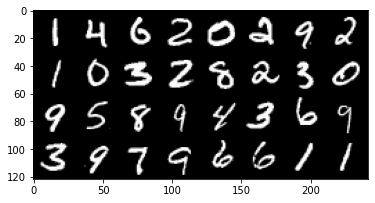

In [ ]:
#data exploration
#get random training data
#some data exploration
#helper function for that 
#pytorch has tensor in the format (channel,width,height) whereas numpy has it (width,height,channel)
# So the transformation is (1,2,0) tells the correct format (width,height,channel)
def imshow(img):
  np_image = img.numpy()
  plt.imshow(np.transpose(np_image,(1,2,0)))

data_iter = iter(train_loader)
images, labels = data_iter.next()

#show the images
imshow(torchvision.utils.make_grid(images))
#note that there are 32 images




In [ ]:
#now the main part ,the code for the actual model
class RoyNet(nn.Module):
  def __init__(self):
    #not sure exactly how this works.Something to do with inheritance,
    super(RoyNet , self).__init__()

    #we use default values of stride = 1
    #and padding = 0
    #our input is (1,28,28)
    #set out_channel as 32,so we get 32 kernels in the layer
    # kernel is = 3
    # therefore output dimension are (26,26,32)
    #self.conv1 = nn.Conv2d(in_channels = 1,out_channels = 32 , kernel_size = 3)


    #we want two linear layers
    #first hidden layer
    #self.d1 = nn.Linear(26*26*32,128)
    
    #ouput layer
    # 10 is the output class
    #self.d2 = nn.Linear(128,10)

    #the sequential is a container
    #takes an input 
    #chains the input - output to the next layer
    #returns the final output
    #input BATCH_SIZE * 1 * 28 * 28 for MNIST
    self.features = nn.Sequential(
        
        #Block 1
        nn.Conv2d(1,32,3,padding = 1),
        nn.ReLU(),
        nn.Conv2d(32,32,3,padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(2,stride = 2,return_indices = True),

        #and 14*14*32 output

        nn.Conv2d(32,32,3,padding = 1),
        nn.ReLU(),
        nn.Conv2d(32,32,3,padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(2,stride = 2,return_indices = True),

        #output  32*7*7



        
    )

    self.classifier = nn.Sequential(
        nn.Linear(32*7*7,512),
        nn.ReLU(),
        nn.Linear(512,10)

    )

    self.feature_maps = OrderedDict() #used to store all feature maps
    self.max_pooling_locations = OrderedDict() #used to store the location of the values from max pools
    self.Convolution_layers_indices = [0,2,5,7]
    
  
  #a function to initialise with a pretrained model
  #has to have the same architecture as the one define above
  #must be compatible with above defined structure of features and classifier
  def initialise_weights(self,model):
    #copy the parameter values for features
    for index,layer in enumerate(model.features):
      #only relevant for learnable parameters,not for Pooling,Relu etc
      if isinstance(layer,nn.conv2d):
        self.features[index].weight.data = layer.weight.data
        self.features[index].bias.data = layer.bias.data
    #copy the parameter values for classifier
    for index,layer in enumerate(model.classifier):
      #only relevant for FC Linear parameters
      if isinstance(layer,nn.Linear):
        self.classifier[index].weight.data = layer.weight.data
        self.classifier[index].bias.data = layer.bias.data

  #function for forward propagation
  def forward(self,x):
    #neccessary for storing the max pool location for inverse pooling
    for index,layer in enumerate(self.features):
      if isinstance(layer,nn.MaxPool2d):
        x, locs = layer(x)
      else:
        x = layer(x)
    #converts a (N,C,H,W) input to (N,C*H*W)
    x = x.view(x.size()[0],-1)
    output = self.classifier(x)
    output = torch.nn.functional.softmax(output,dim = 1)
    return output



  


  '''
  #code for forward propagation
  def forward(self, x):
    # 32*1*28*28 => 32*32*26*26
    x = self.conv1(x)
    x = F.relu(x)

    # Flatten the layer => 32X(32*26*26)
    x = x.flatten(start_dim = 1)

    #(32,32*26*26) => (32,128)
    x = self.d1(x)
    x = F.relu(x)

    #(32,128) = > (32,10)
    logits = self.d2(x)
    output = F.softmax(logits,dim = 1)
    return output
  '''
  






    






In [ ]:
%ls drive/MyDrive

 2019111020_quiz6.txt.gdoc
 2019111020_quiz7.gdoc
 2019111020_Science-2_Assignment1.gdoc
 2019111020_tut.gdoc
'AC Circuit_1.pdf'
'ac circuits.pdf'
'Ashis Nandy (ed.), Jatinder K Bajaj, Claude Alvares, Shiv Visvanathan, Manu Kothari, Lopa Mehta, Veena Das, Vandana Shiva-Science, Hegemony and Violence_ A Requiem for Modernity (1990).pdf'
 Assignment3.gdoc
 BABAsanti
 Blockchain.gslides
'Boarding Pass.pdf'
 bohr.pdf
'Colab Notebooks'/
 compton.pdf
'computer project.pdf'
"Copy of The Principal Gokhale Memorial Girls' College 2.gdoc"
 CPNA_Lecture_10_Interpolation.pdf
'Deshbandhu college for girls.gdoc'
'Determination of EMF-1.pdf'
 DIP_Project_Proposal.md
 ESW.gdoc
'ESW Project Report.gdoc'
'ESW Project - Wearable Sensors.gslides'
'Final letter (1).docx'
'Final letter (1).gdoc'
'Final letter (2).gdoc'
'Final letter.docx'
'Final letter.gdoc'
'Flash Matting (1).gslides'
'Flash Matting.gslides'
'Getting started.pdf'
'Goenka College of Commerce and Business Adminstration.gdoc'
'Government Coll

In [ ]:
''' training '''
import time
learning_rate = 0.0005
num_epochs = 3
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = RoyNet()
#moves the model to the device gpu
model = model.to(device)
cost = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters() , lr = learning_rate)


''' computes the accuracy or conversely error rate '''
''' used for training purposes '''
def Accuracy(logit,target,batch_size = BATCH_SIZE):
  # correct has the value of number of right classifications 
  corrects = (torch.max(logit,1)[1].view(target.size()).data == target.data).sum()
  accuracy = corrects / batch_size
  return accuracy.item()

for epochs in range(num_epochs):
  t1 = time.time()
  train_running_loss = 0
  train_accuracy = 0

  #tells the model that it is in the training phase,so stuff like batchnorm and 
  #dropout behave accordingly
  model = model.train()

  for i,(images,labels) in enumerate(train_loader):
    #sends the images and the labes to the gpu
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    images = images.to(device)
    labels = labels.to(device)

    #forward pass 
    logits = model(images)

    #compute Cross Entropy Loss
    loss = cost(logits,labels)

    #set the gradients to zero
    optimizer.zero_grad()

    #back prop
    loss.backward()

    #update model parameter
    optimizer.step()

    #update loss
    train_running_loss += loss.detach().item()
    train_accuracy += Accuracy(logits,labels,BATCH_SIZE)
  
  #saves the model
  torch.save(model, "./drive/MyDrive/model.pth")
  #tells the model it is evals phase
  model.eval()
  t2 = time.time()
  print("Time taken for the current epoch is {0}".format(t2 - t1))
  print(" Epoch : %d   |   Loss : %0.4f   |   Accuracy : %0.2f"  
        %(epochs , train_running_loss / i , train_accuracy / i))
  


  



Time taken for the current epoch is 155.2066686153412
 Epoch : 0   |   Loss : 1.5676   |   Accuracy : 0.17


/usr/local/lib/python3.7/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type RoyNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Time taken for the current epoch is 193.06343388557434
 Epoch : 1   |   Loss : 1.4900   |   Accuracy : 0.42
Time taken for the current epoch is 297.618036031723
 Epoch : 2   |   Loss : 1.4841   |   Accuracy : 0.49


In [ ]:
#see test accuracy
test_accuracy = 0
for i,(images,labels) in enumerate(test_loader,0):
  images = images.to(device)
  labels = labels.to(device)

  outputs = model(images)
  test_accuracy += Accuracy(outputs,labels,BATCH_SIZE)

print('Test Accuracy: %.2f'%( test_accuracy/i))



Test Accuracy: 0.55


In [ ]:



input = torch.randn(32, 1, 28, 28)

F = nn.MaxPool2d(2,stride = 2,return_indices= False)
F1 = nn.Conv2d(1,32,3,padding = 1)

'''
#print(input)
#F1 = nn.Conv2d(1,32,3,padding = 1)
#print(F1(input).shape)
print(F1.weight.data.shape)
print(F1.bias.data.shape)

input = F(input)
out = F1(input)
print(out.shape)
new_out = out.view(out.size()[0],-1)
print(new_out.shape)
output = f1()
'''
output = F(input)
print(output.shape)
print(output[0].shape,output[1].shape)


torch.Size([32, 1, 14, 14])
torch.Size([1, 14, 14]) torch.Size([1, 14, 14])


In [ ]:
#this is the twin Deconvnet of the above Conv net called Roy Net
class Roy_Deconv(nn.Module) :
  def __init__(self):
        super(Roy_Deconv, self).__init__()

    #now the inverse of the above convnet
    #input BATCH_SIZE * 32 * 7 * 7
        self.features = nn.Sequential(
          nn.MaxUnpool2d(2,stride = 2),
          nn.ReLU(),
          nn.ConvTranspose2d(32,32,3,padding = 1),
          nn.ReLU(),
          nn.ConvTranspose2d(32,32,3,padding = 1),

          #output = 32*14*14

          nn.MaxUnpool2d(2,stride = 2),
          nn.ReLU(),
          nn.ConvTranspose2d(32,32,3,padding = 1),
          nn.ReLU(),
          nn.ConvTranspose2d(32,1,3,padding = 1)

          #output = 1*28*28


        
        
      )
        #this maps the indices of the layer of in conv net architecture with the deconvnet architecture
        #{forward_ind : backward_ind}
        self.conv_deconv_layer_index_mapping = {0:9 , 2:7 , 5:4, 7:2} 

        #this maps the bias of the conv layer with the deconv layer.For some reason this does not 
        #perfectly allign with above transformation because the first backward layer is randomly set
        #{forward_ind : backward_ind}
        self.conv_deconv_layer_bias_index_mapping = {0:7 , 2:4 , 5:2 }

        #this maps the forward and backward relu layer
        #{forward_ind : backward_ind}
        self.relu_relu_layer_index_mapping = {1:8 , 3:6 ,6:3 ,8:1}

        #this maps the forward maxpool layer index to the backward maxunpool netword
        #{backward_ind : forward}
        self.unmaxpool_maxpool_layer_index_mapping = {0:9, 5:4}

  #this updates the parameters of the deconv model from the passed parameter which is the forward model
  def update_weights(self, model):

    #update the paramters
    for index,layer in enumerate(model.features):
      if isinstance(layer,nn.Conv2d):
        self.features[self.conv_deconv_layer_index_mapping[index]].weight.data = layer.weight.data
        if index in self.conv_deconv_layer_bias_index_mapping:
          self.features[self.conv_deconv_layer_bias_index_mapping[index]].bias.data = layer.bias.data
          #print("do")
  #forward pass to obtain the inverse image
  #pool locs is useful for maxunpooling
  #layer is the index of the layer from which x is passed(I think)
  #I am not too sure
  #The input layer should be a RELU or CONV
  #Not sure why Maxpooling layer not allowed
  def forward(self, x , layer  , pool_locs):
    print("Forward")
    if layer in self.conv_deconv_layer_index_mapping:
      start_index = self.conv_deconv_layer_index_mapping[layer]
    elif layer in self.relu_relu_layer_index_mapping:
      start_index = self.relu_relu_layer_index_mapping[layer]
    else:
      print("The given layer is not RELU or Conv,exiting")
      #sys.exit(0)
    
    for index in range(start_index,len(self.features)):
      if isinstance(self.features[index] , nn.MaxUnpool2d):
        print("Unpool")
        x = self.features[index](x,pool_locs[self.unmaxpool_maxpool_layer_index_mapping[index]])
      else:
        if isinstance(self.features[index],nn.ConvTranspose2d):
          print("Transpose")
        if isinstance(self.features[index],nn.ReLU):
          print("RElu")
        x = self.features[index](x)
    return x

    







In [ ]:
#Function to visualize a feature map in a grid
#feature map is the shape (C,W,H,N)
#this part is I dont understand that well
#utility function for visualization
def visualize_feature_map(feature_map):
  (C,W,H,N) = feature_map.shape
  cnt = int(ceil(sqrt(C)))
  G = np.ones((cnt*H + cnt,cnt*W + cnt,N),feature_map.dtype)#the extra cnt is for black colored spacing
  G *= np.min(feature_map)

  n = 0
  for row in range(cnt):
    for col in range(cnt):
      if n < C:
        #additional cnt for spacing
        G[row*H + row : (row + 1)*H + row, col*W + col : (col + 1)*W + col,:] = feature_map[n,:,:,:]
        n += 1

  #Normalize G
  G = (G - G.min())/(G.max() - G.min())
  return G


#function to visualize a layer represented by a grid
#again do not understand this part much
def visualize_layer(feature_layer_grid):
  plt.clf() #clears figure
  plt.subplot(121)
  plt.imshow(feature_layer_grid[:,:,0],cmap = 'gray')


#transform a deconvolutional image to a normal one(Also normalize)
#input is the output of the deconvolated image
def transform_deconvolved_image(output) :
  d_img = output.data.numpy()[0].transpose(1,2,0) #gets it to (H,W,C) format
  d_img = (d_img - d_img.min())/(d_img.max() - d_img.min()) #normalize
  return d_img.astype(np.uint8)


#function to store all the feature maps and max_pooling locations
def store_all_feature_maps(model):
  #this is a function that is to be passed to another function
  #It will be called everytime forward is called on model
  def hook(module,input,output,key):
    if isinstance(module,nn.MaxPool2d):
      #remember the maxpool layer returns two values x,loc because return_indices is set to true
      model.feature_maps[key] = output[0] #stores the feature map to the ordereddict
      model.max_pooling_locations[key] = output[1] #stores the location
    else:
      model.feature_maps[key] = output
  for index,layer in enumerate(model._modules.get('features')):  
    #register forward hook makes the hook to be called whenever forward is called
    #partial allows hook to be called hook(module,input,output,key = index)
    layer.register_forward_hook(partial(hook,key = index))

  





/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


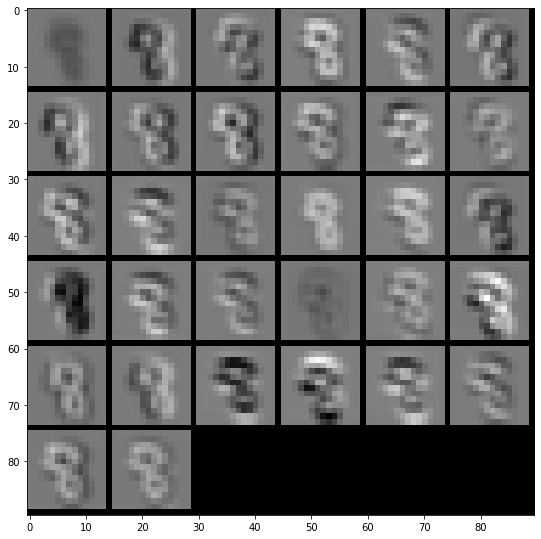

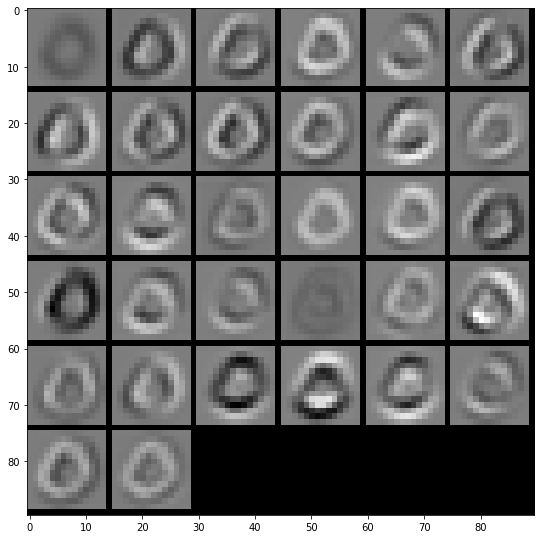

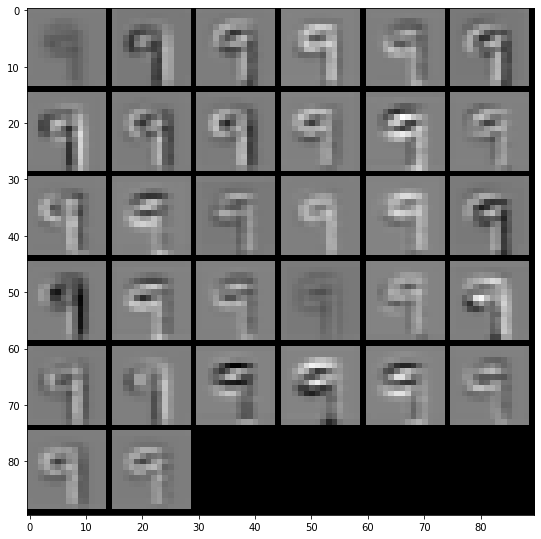

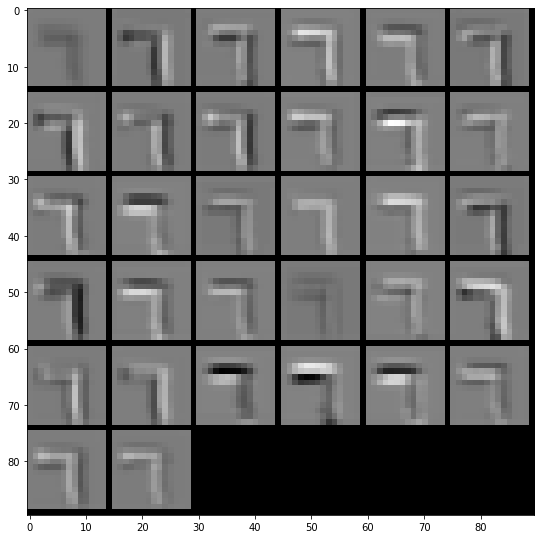

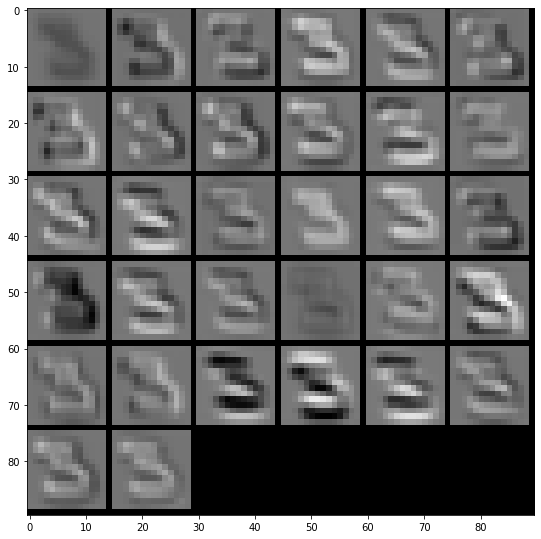

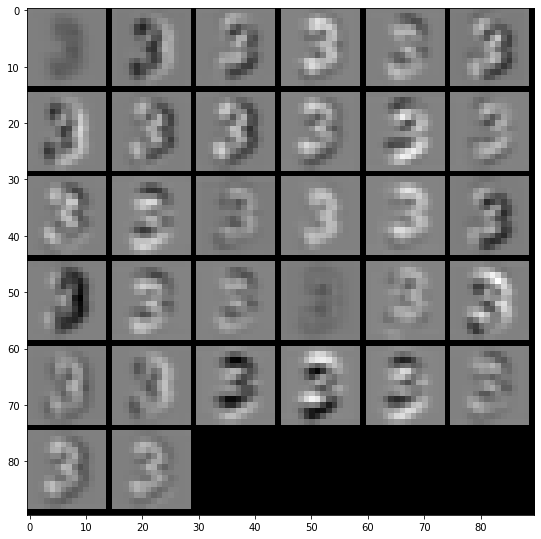

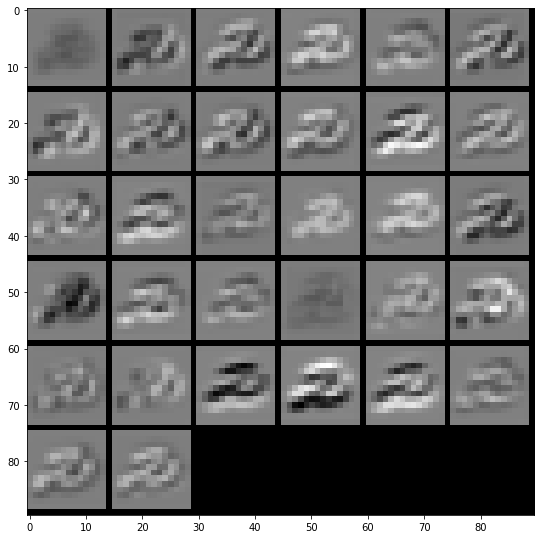

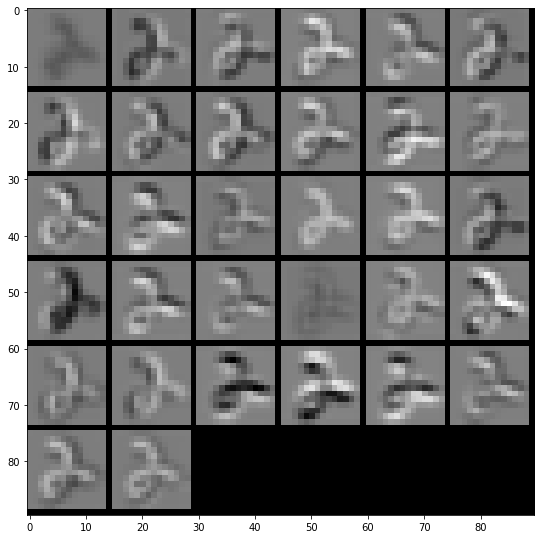

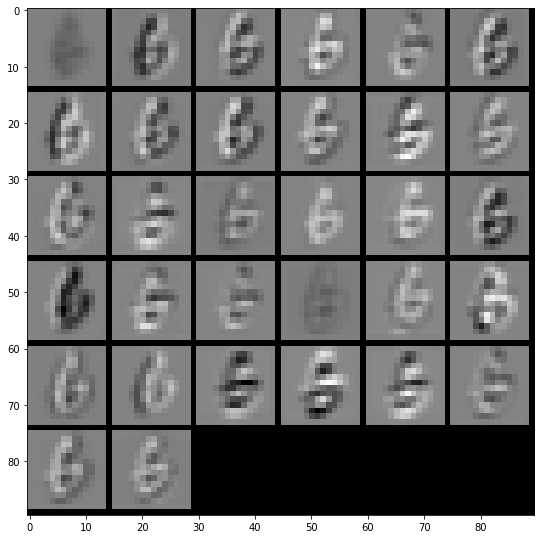

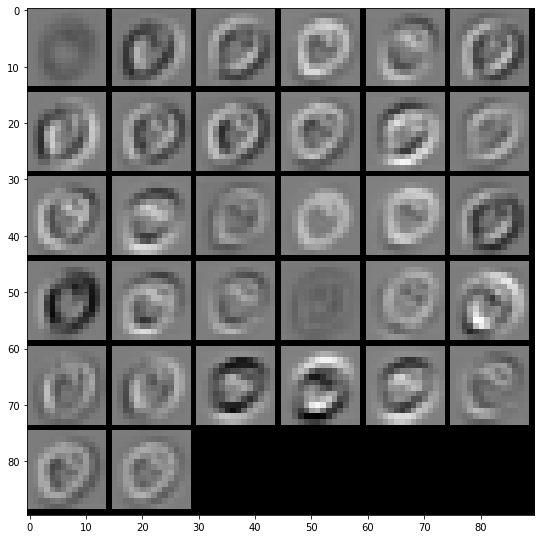

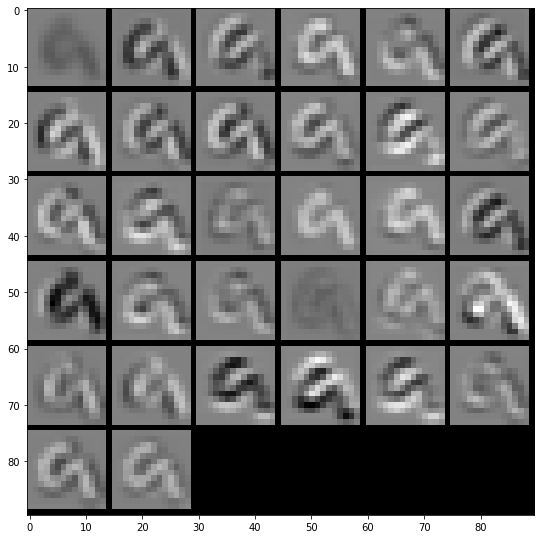

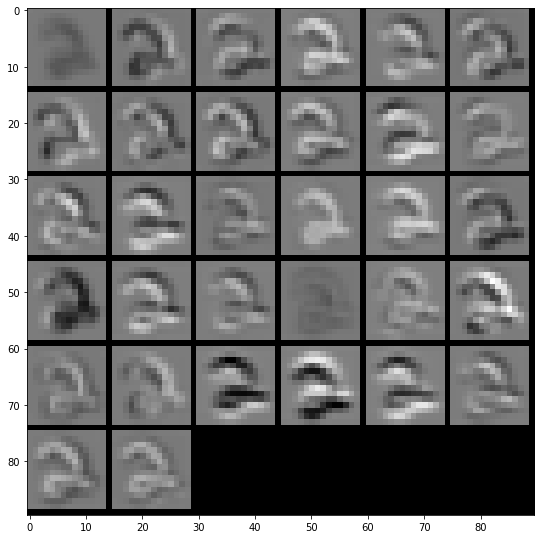

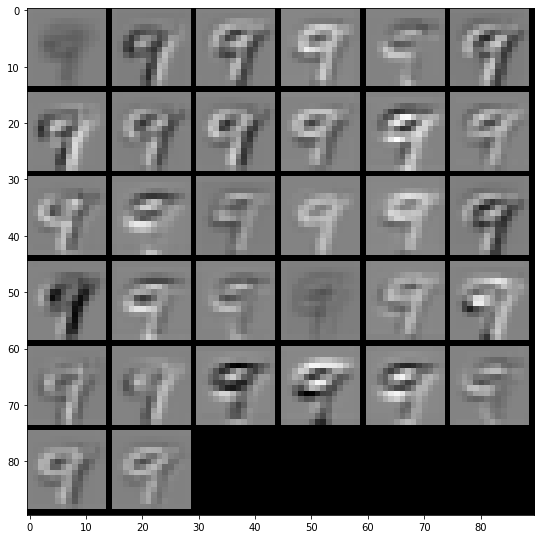

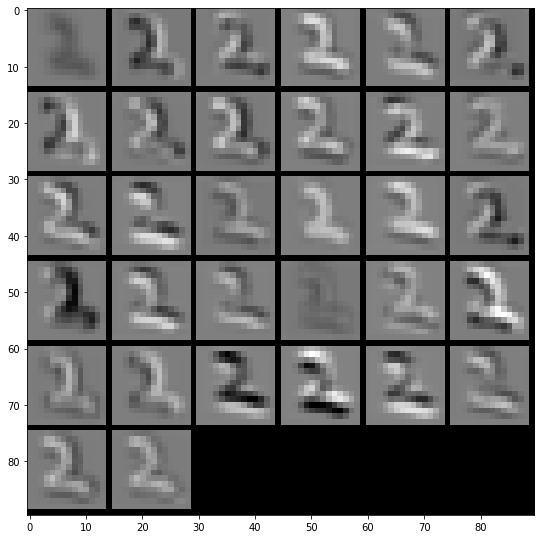

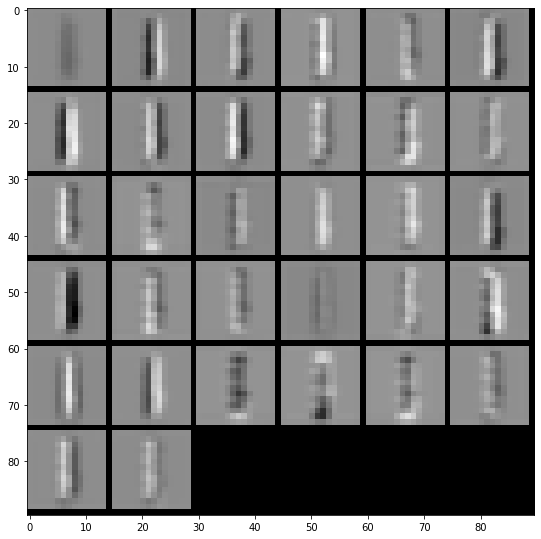

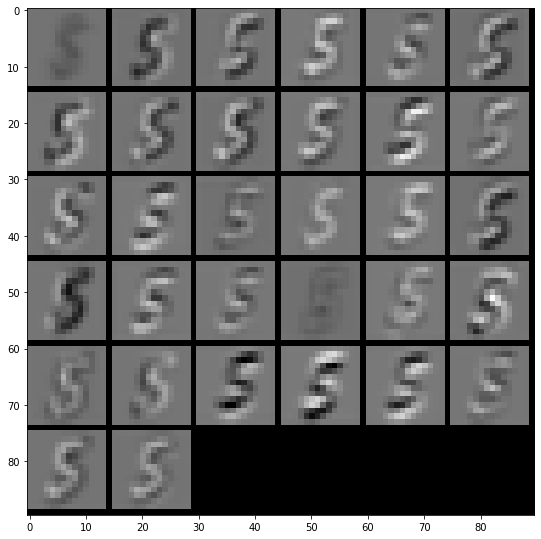

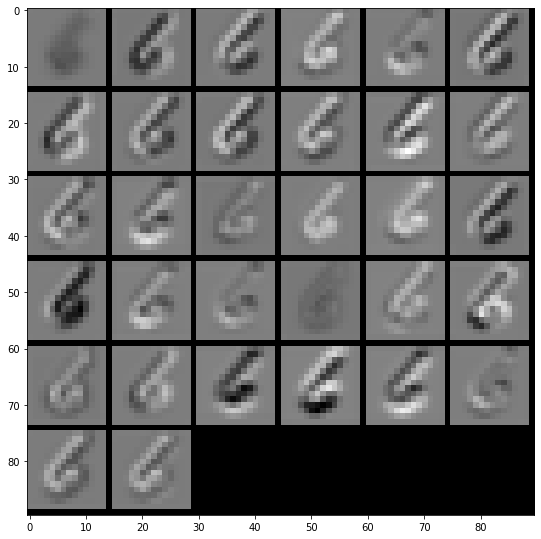

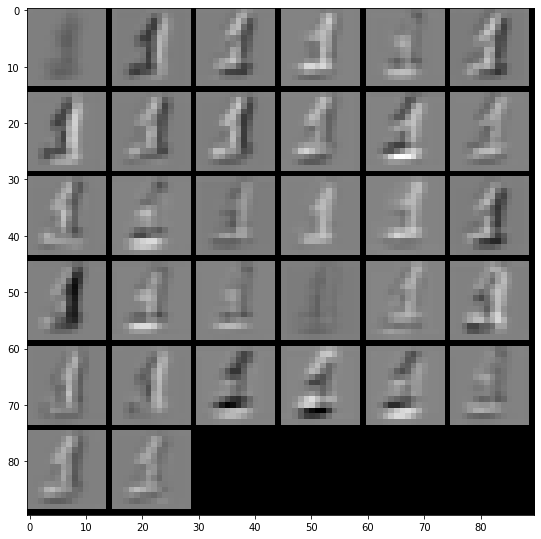

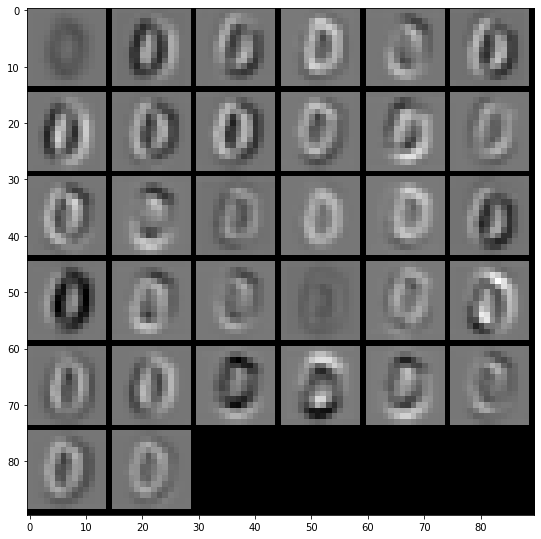

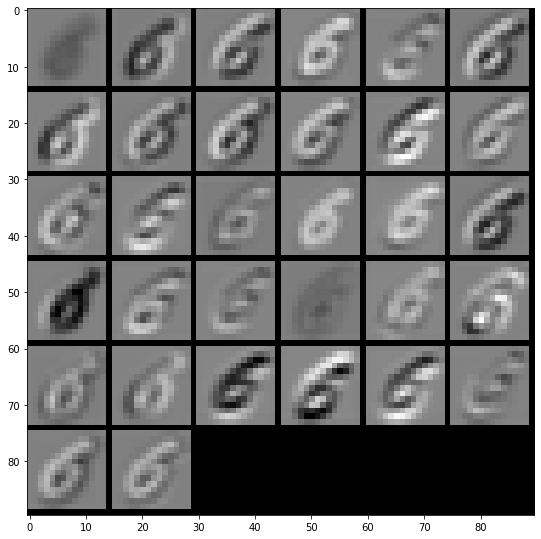

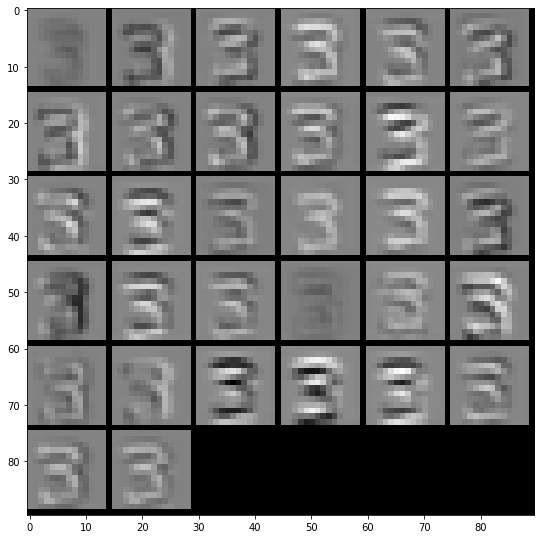

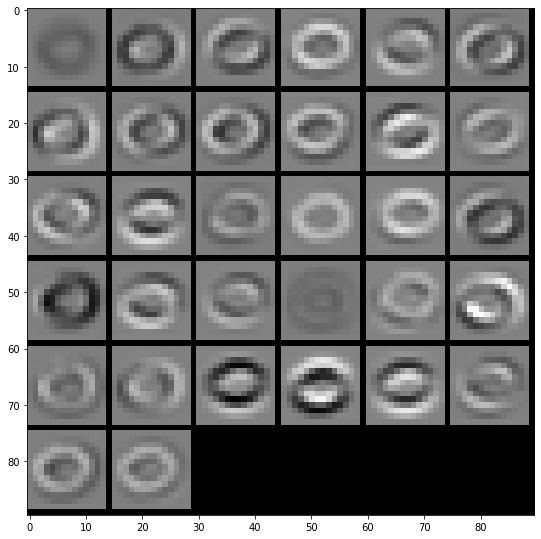

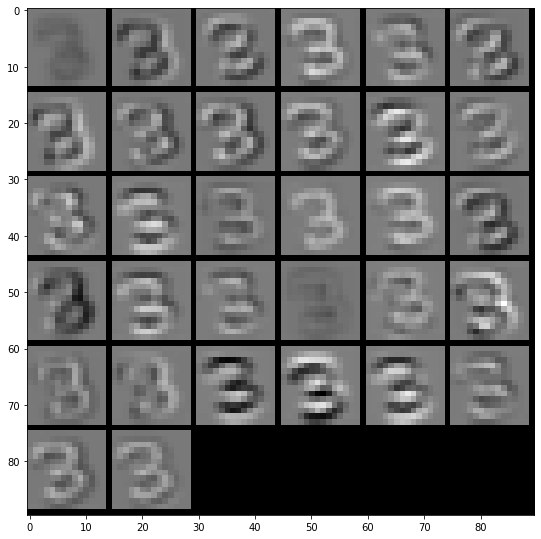

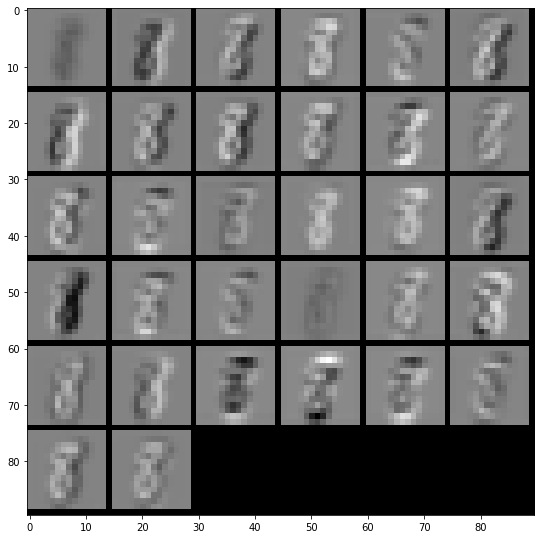

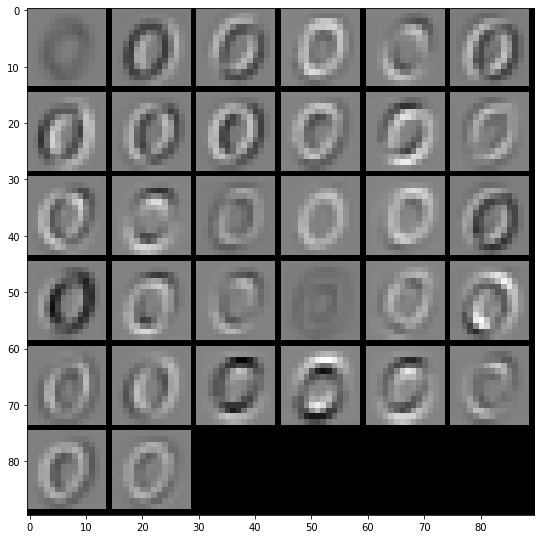

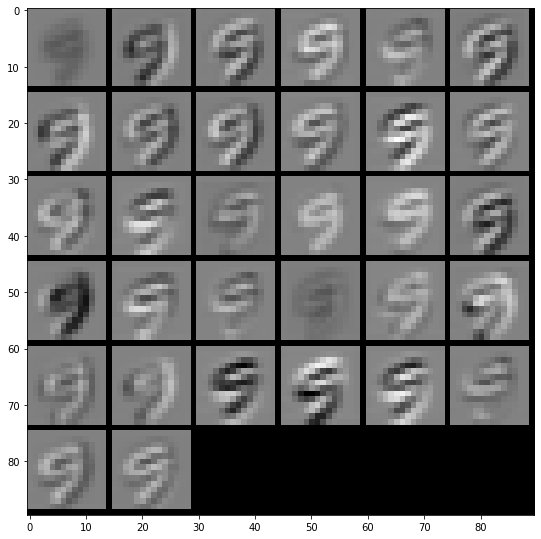

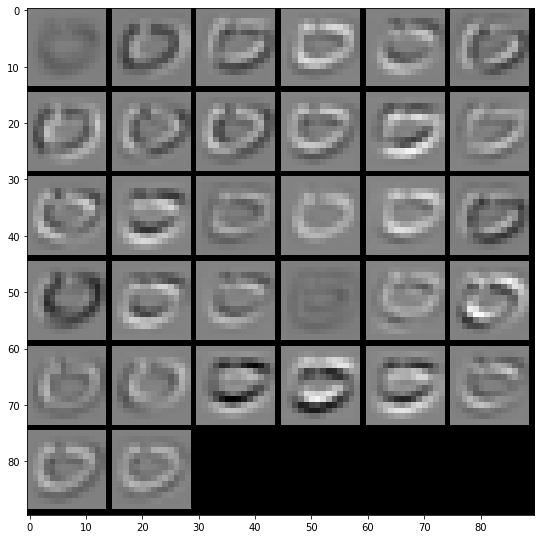

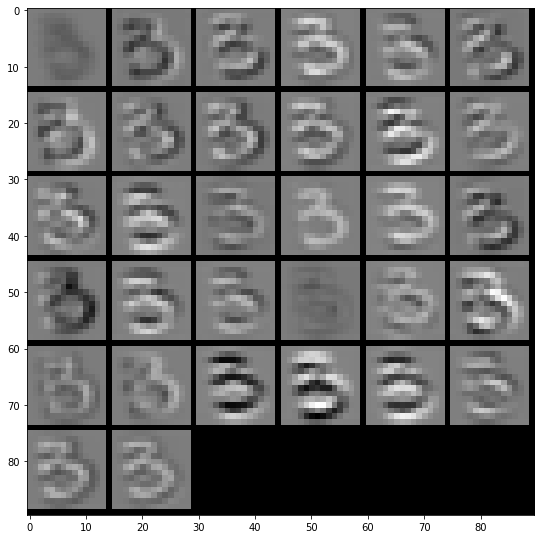

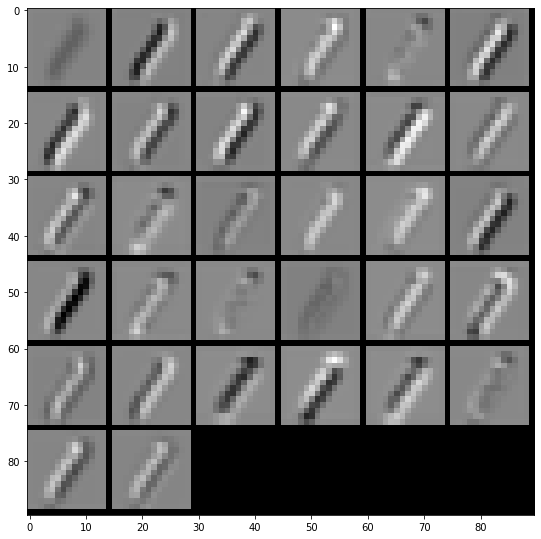

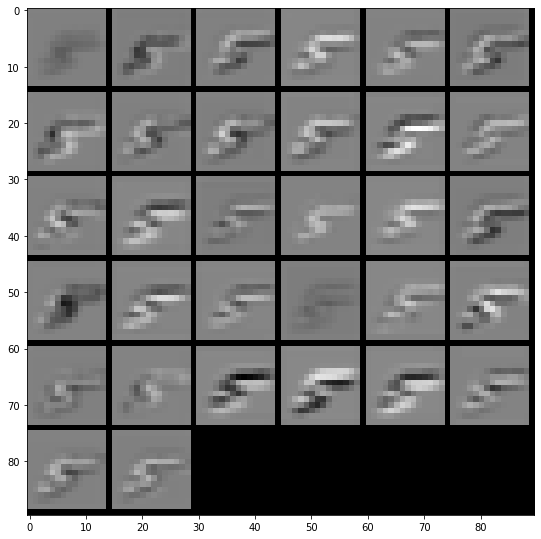

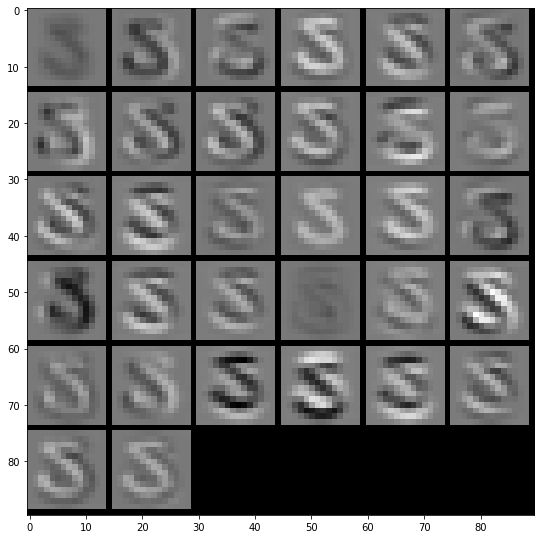

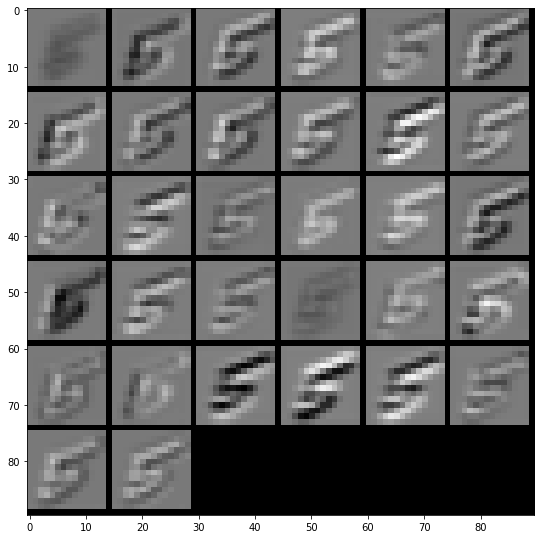

In [ ]:
data_iter = iter(train_loader)
images, labels = data_iter.next()
#print(images.shape)
#print(np.transpose(images[0],(1,2,0)).shape)
images_print = []
images_model = []
for i in range(images.shape[0]):
  im = np.transpose(images[i],(1,2,0))[:,:,0]
  images_print.append(im)
  im1 = images[i]
  im1 = im1[np.newaxis,:,:,:]
  #im = im[np.newaxis,:,:,:] # add one dim in the beginning

  images_model.append(im1)

#let th model be in eval
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()


#ask the model to store feature maps and location
store_all_feature_maps(model)



for i in range(len(images_model)):


  im = images_model[i]
  im = im.to(device)

  #send it to the CNN
  forward_output = model(im)


 

  plt.ion() #removes blocking not sure what that is
  plt.figure(figsize = (20,20))
  layer = 5
  feature_map = model.feature_maps[layer].cpu().data.numpy().transpose(1,2,3,0) # converts (N,C,H,W) to (C,H,W,N) where N = 1
  feature_map_grid = visualize_feature_map(feature_map)
  visualize_layer(feature_map_grid)








(32, 28, 28, 1)
32 28 28
(90, 90, 1)
torch.Size([1, 32, 28, 28])
Forward
Transpose
output data
torch.Size([1, 1, 28, 28])
torch.Size([28, 28])


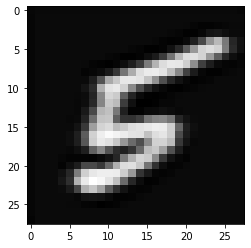

In [ ]:
print(feature_map.shape)
C,H,W,_ = feature_map.shape
print(C,H,W)
print(feature_map_grid.shape)
#stuff to do with formatting the visualizations
G_H,G_W ,_ = feature_map_grid.shape
col_steps = G_W / (W + 1)
new_feature_map = model.feature_maps[layer].clone()
print(new_feature_map.shape)
#deconv_output 
#Initialise the deconvModel
deconv_model = Roy_Deconv()
#print(model.features[0].weight.data)
deconv_model.update_weights(model)
deconv_model = deconv_model.to(device)
deconv_model.eval()
new_feature_map = new_feature_map.to(device)
deconv_output = deconv_model(new_feature_map , layer , model.max_pooling_locations)

print("output data")
print(deconv_output.shape)
r = deconv_output.cpu()[0][0][:][:]
print(r.shape)
#print(r)
plt.imshow(r.detach().numpy(),cmap = 'gray')


In [ ]:
def get_training_set(train_loader):
  train_set = []
  for i,(images,labels) in enumerate(train_loader):
    for j in range(images.shape[0]):
      x = images[j].unsqueeze(0)
      #print(x.shape)
      train_set.append(x)
  return train_set

train_set = get_training_set(train_loader)
print(len(train_set),train_set[i].shape)


60000 torch.Size([1, 1, 28, 28])


In [ ]:
def visualize_features(model,activations_index):
  activations = []
  for image in train_set:
    image = image.to(device)
    output = model(image)
    feature_map = model.feature_maps[0].clone()
    feature_map = model.feature_maps[0].cpu().data.numpy().transpose(1,2,3,0)[rand] # converts (N,C,H,W) to (C,H,W,N) where N = 1
    print(feature_map.shape)
    activation = feature_map[:][:][0]
    print(activation.shape)
    val = np.linalg.norm(activation,2)
    print(val)

Forward
Transpose
RElu
Transpose
Unpool
RElu
Transpose
RElu
Transpose
torch.Size([28, 28])


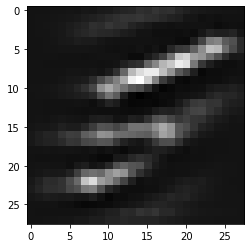

In [ ]:
activation_index = 5
layer = 7 #0,2,5,7 are valid indices for Conv 0 indexed
feature_map = model.feature_maps[layer].data.numpy().transpose(1, 2, 3, 0) # (1, C, H, W) -> (C, H, W, 1)
#feat_map_grid = visualize_feature_map(feature_map)  # represent a feature map in a grid
#visualize_layer(feat_map_grid)
number_of_activations = feature_map.shape[0] #total number of activation

if activation_index >= number_of_activations:
  print("Activation index Invalid")
else:
  new_map = model.feature_maps[layer].clone() # (1,C,H,W)
  if activation_index == 0:
    new_map[:,1:,:,:] = 0
  else:
    new_map[:,:activation_index,:,:] = 0
    if activation_index < new_map.shape[1] - 1:
      new_map[:,activation_index + 1 :,:,:] = 0
  #print("Deconvolution")
  deconv_output = deconv_model(new_map , layer , model.max_pooling_locations)
  r = deconv_output.cpu()[0][0][:][:]
  print(r.shape)
#print(r)
  plt.imshow(r.detach().numpy(),cmap = 'gray')


  









#map = torch.tensor(map)
#g = deconv_model(map, 1 , model.max_pooling_locations)
  


In [ ]:
#map = torch.from_numpy(map)
print(map.shape)
print(device)


torch.Size([1, 32, 28, 28])
cuda:0


In [ ]:
deconv_model = D
deconv_model.to(device)
map.to(device)
model.to(device)
print(map.shape)
out = deconv_model(map,0,model.max_pooling_locations)

torch.Size([1, 32, 28, 28])


In [ ]:
print(model)
deconv_model = Roy_Deconv()
#print(model.features[0].weight.data)
deconv_model.update_weights(model)
deconv_model = deconv_model.to(device)
deconv_model.eval()
print(deconv_model)

RoyNet(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=1568, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=10, bias=True)
  )
)
Roy_Deconv(
  (features): Sequential(
    (0): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
    (1): ReLU()
    (2): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(32, 32

In [ ]:
out = deconv_model(map,0,model.max_pooling_locations)